# Restaking EL-rewards evaluation

In [91]:
# Derived from https://github.com/lidofinance/Beaconchain_model/blob/main/queue_modeling.ipynb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import requests
import logging

%matplotlib inline

SLOTS_PER_EPOCH = 32
SECONDS_PER_SLOT = 12
EPOCHS_PER_YEAR = 82180
EPOCHS_PER_DAY = 225
SECONDS_PER_YEAR = 31556952

MERGE_EPOCH = 122962
MERGE_VALIDATORS = 319936

validators_per_epoch_forecasted = 1.137662835249042 

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n: int) -> float:
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators: int) -> float: # mean
    return SECONDS_PER_YEAR / (12 * no_of_validators) # 12 seconds = 1 slot

def get_epoch_data(epoch: str = "latest") -> str:
    try:
        req = requests.get(f"https://beaconcha.in/api/v1/epoch/{epoch}", headers={"accept":"application/json"})
        req.raise_for_status()
        return req.json()["data"]
    except requests.exceptions.HTTPError as err:
        logging.error(err)
        return {}

def day_to_epoch(day_number_from_merge: int) -> int:
    return merge_epoch + (day_number_from_merge * EPOCHS_PER_DAY)

def epoch_to_day(epoch: int) -> int:
    return (epoch - merge_epoch) // EPOCHS_PER_DAY

def get_validators_at_epoch(epoch: int) -> int:
    return merge_validators + validators_per_epoch_forecasted * (epoch - merge_epoch) 
    

In [92]:
priority_fee_monthly  = 21539 # https://dune.xyz/queries/382535
avg_mev_reward_per_block = 0.185 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles
today_validators = validators_on_the_network_today = get_epoch_data(epoch="latest")['validatorscount']
max_number_of_validators = 40_000_000 // 32
altair_multiplier = 0.855 # Altair hardfork block reward multiplier


# Verification stake
initial_stake = 320
years = 3

# Day 0: entry point
days = round(years * 365.) + 1

x = np.zeros(days)
for d in range(days):
    x[d] = d

In [93]:
# Ideal, with and without MEV/tx fee

lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = max_number_of_validators * 32

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n) * altair_multiplier) for n in n_validators]
ideal_reward_with_mev_and_pf = [(
    4 * annualised_base_reward(n) * altair_multiplier
    + (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) 
    + priority_fee_monthly*12/n
) for n in n_validators]

In [94]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators

n_validators = [get_validators_at_epoch(day_to_epoch(d)) for d in x]
ideal_reward = [(4 * annualised_base_reward(n) * altair_multiplier) for n in n_validators]
ideal_reward_with_mev_and_pf = [(
    4 * annualised_base_reward(n) * altair_multiplier
    + (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) 
    + priority_fee_monthly*12/n
) for n in n_validators]

staked = [32 * n for n in n_validators] # ETH actively staked in the network
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev_and_pf]

simple_DPR = [v / 365. for v in annual_yield_with_mev]
mev_tx_DPR = np.subtract(annual_yield_with_mev, annual_yield) / 365.

## Straightforward benchmark (without reinvesting)

$\begin{align}
y\_benchmark_{0} = initial\_stake \\
y\_benchmark_{day} = y\_benchmark_{day} + initial\_stake * \frac{simple\_DPR_{day}}{100})
\end{align}$

In [95]:
# Benchmark goes without restaking

y_benchmark = np.zeros(days)

y_benchmark[0] = initial_stake
for day in range(1, days):
    y_benchmark[day] = y_benchmark[day-1] + simple_DPR[day]/100. * initial_stake

## Restaking scheme (compound interest for the EL-rewards)

$\begin{align}
y\_restaking_{0} = initial\_stake \\
y\_restaking_{day} = y\_restaking_{day-1} + initial\_stake * (\frac{simple\_DPR_{day}}{100}) * (1 + \frac{mev\_tx\_DPR_{day}}{100})^{day} 
\end{align}$

In [96]:
# Balances with restaking

y_restaking = np.zeros(days)
y_restaking[0] = initial_stake

for d in range(1, days):
    day_d_stake = initial_stake * (1+mev_tx_DPR[d] / 100.)**d
    day_d_delta = simple_DPR[d] / 100. * day_d_stake
    y_restaking[d] = y_restaking[d-1] + day_d_delta    

### Plots

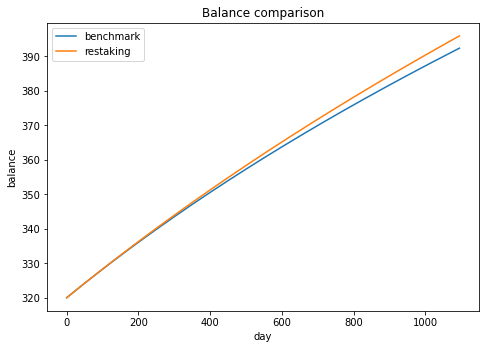

In [97]:
fig=plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.plot(x,y_benchmark, label="benchmark")
ax.plot(x,y_restaking, label="restaking")
ax.set_title("Balance comparison")
ax.set_xlabel("day")
ax.set_ylabel("balance")
ax.legend()

## Overall results

In [98]:
print(f"final benchmark balance: {y_benchmark[days-1]}")
print(f"final restaking balance: {y_restaking[days-1]}")

b_APR = (y_benchmark[days-1]-initial_stake)/initial_stake * 100. / ((days-1) / 365.)
print(f"benchmark APR: {b_APR:.2f}%")

r_APY = (y_restaking[days-1]-initial_stake)/initial_stake * 100. / ((days-1) / 365.)
print(f"restaking APY: {r_APY:.2f}%")

print(f"APY/APR diff: {r_APY-b_APR:.2f}%")

final benchmark balance: 392.4013170327173
final restaking balance: 395.9643459130273
benchmark APR: 7.54%
restaking APY: 7.91%
APY/APR diff: 0.37%
